Keras Denoising Autoencoder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, TensorBoard
from tensorflow.keras.utils import to_categorical

# versioning
import tensorflow as tf
print(f"Tensorflow {tf.__version__}")
print(f"Keras {tf.keras.__version__}")

Tensorflow 2.4.1
Keras 2.4.0


In [3]:
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
# normalize the training data
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
print(x_train.shape)

(60000, 28, 28, 1)


In [5]:
# normalize the test data
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_test.shape)

(10000, 28, 28, 1)


In [6]:
noise_factor = 0.5

In [7]:
# create noisy data for train
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
print(x_train_noisy.shape)

(60000, 28, 28, 1)


In [8]:
# create noisy data for test
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_test_noisy.shape)

(10000, 28, 28, 1)


In [9]:
# create the encoder network
input_image = Input(shape=(28,28,1))
x = Conv2D(32,(3,3),activation='relu',padding='same')(input_image)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(32,(3,3),activation='relu',padding='same')(x)
encoded = MaxPooling2D((2,2),padding='same')(x)

encoder = Model(input_image, encoded)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


In [10]:
# create the decoder network
decoder_input= Input(shape=(7,7,32))
x = Conv2D(32,(3,3),activation='relu',padding='same')(decoder_input)
x = UpSampling2D((2,2))(x)
x = Conv2D(32,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

decoder = Model(decoder_input, decoded)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 32)]        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 18,785
Trainable params: 18,785
Non-trainable params: 0
_______________________________________________________

In [11]:
# create the autoencoder by tying the encode and decode networks together
autoencoder_input = Input(shape=(28,28,1))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 7, 7, 32)          9568      
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         18785     
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
# train using the noisy images with their clean counterparts
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
  epochs=10,
  batch_size=128,
  shuffle=True)

Epoch 1/10
469/469 [==============================] - 42s 88ms/step - loss: 0.2625
Epoch 2/10
469/469 [==============================] - 42s 89ms/step - loss: 0.1169
Epoch 3/10
469/469 [==============================] - 41s 88ms/step - loss: 0.1098
Epoch 4/10
469/469 [==============================] - 41s 88ms/step - loss: 0.1057
Epoch 5/10
469/469 [==============================] - 41s 88ms/step - loss: 0.1029
Epoch 6/10
469/469 [==============================] - 43s 91ms/step - loss: 0.1015
Epoch 7/10
469/469 [==============================] - 43s 92ms/step - loss: 0.1004
Epoch 8/10
469/469 [==============================] - 44s 94ms/step - loss: 0.0995
Epoch 9/10
469/469 [==============================] - 44s 94ms/step - loss: 0.0989
Epoch 10/10
469/469 [==============================] - 42s 90ms/step - loss: 0.0980


In [13]:
# run the first 10 noisy test images through the encoder
encoded_imgs = encoder.predict(x_test_noisy[:10])
print(encoded_imgs.shape)

# run encoded noisy test images back through the decoder
decoded_imgs = decoder.predict(encoded_imgs)
print(decoded_imgs.shape)

(10, 7, 7, 32)
(10, 28, 28, 1)


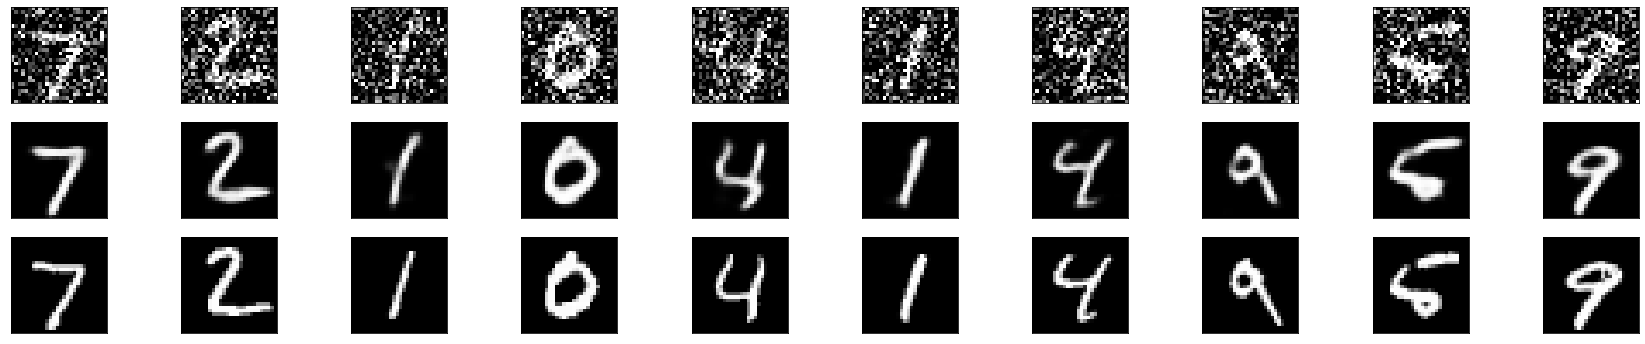

In [14]:
# display the images
n = 10
plt.figure(figsize=(30,6))
for i in range(n):
  # noisy images
  ax = plt.subplot(3,n,i+1)
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # denoised images
  ax = plt.subplot(3,n,i+1+n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # original images
  ax = plt.subplot(3,n,i+1+n*2)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()